In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split

In [17]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
    return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)

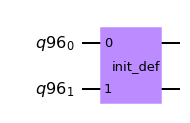

In [18]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
c = QuantumCircuit(q)
# c.initialize(normalize([0,1,3,1]))

# # c.measure([0,1], [0,1])
c.append(extensions.Initialize(normalize([0,1,3,1])).definition, [0,1])
c.draw(output='mpl')

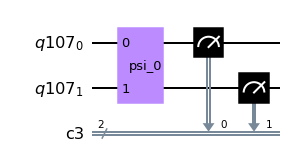

In [19]:
gate = init_gate([0,2,10], "psi_0")
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
qc.append(gate, [0,1])
qc.measure(q,c)
qc.draw(output='mpl')

In [20]:
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10000)
result = job.result()

# print(result.get_counts())
counts = result.get_counts()
print(counts)
print({k:math.sqrt(c) for (k,c) in counts.items()})

{'01': 403, '10': 9597}
{'01': 20.074859899884732, '10': 97.9642792042079}


In [21]:
bits = 4

for i in range(4 ** 2):
    number = ""
    for j in range(bits):
        bit = (i >> j) & 1
        number += str(bit)
    print(number[::-1])

0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111


In [22]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [24]:
def construct_oracle(data, labels):
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
    print(len(data), data.shape[0])
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits).control(counting_bits)
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

In [25]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
#     print(circuit)
    return circuit.to_gate(label="destructive_swap")


In [26]:
def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
#         print(k, success)
#         success = k.count('1') % 2 == 0
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [39]:
def construct_classifier(data, labels):
    input_size = math.ceil(math.log2(data.shape[1]))
    oracle, data_bits, counting_bits = construct_oracle(data, labels)
    print(oracle)
    oracle = oracle.to_gate(label="oracle")
    q = QuantumRegister(input_size + data_bits + counting_bits + 1)
    c = ClassicalRegister(input_size * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[input_size:])
#     print(input_size)
    qc.append(destructive_swap(input_size), q[:input_size] + q[input_size:input_size+input_size])
    for i in range(input_size * 2 + 1):
        qc.measure(i,i)
    return qc


In [55]:
df = pd.read_csv("bezdekIris.data", header=None)

In [56]:
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
df = df[df[4] != 0]

In [57]:
train, test = train_test_split(df, test_size=0.36)
data = train[[0,1,2,3]].to_numpy()
labels = train[4].to_numpy()

In [58]:
print(labels)

[2 2 1 1 2 1 1 1 2 2 2 2 1 1 1 1 1 2 1 2 1 2 2 1 2 2 2 1 2 1 2 2 2 1 2 1 2
 1 2 1 1 1 2 1 1 1 2 1 2 2 1 1 1 2 1 2 1 1 2 1 2 2 2 1]


In [59]:
# data = np.ones((20,4))
# data = np.array([np.array([1,2,0,4]) for i in range(20)])


qc_classifier = construct_classifier(data, labels)


64 64
                   ┌────────┐          ┌────────┐          ┌────────┐          »
q2982_0: ──────────┤0       ├──────────┤0       ├──────────┤0       ├──────────»
                   │  psi_0 │          │  psi_1 │          │  psi_2 │          »
q2982_1: ──────────┤1       ├──────────┤1       ├──────────┤1       ├──────────»
                   └───┬────┘          └───┬────┘          └───┬────┘┌───┐     »
q2982_2: ──────────────┼───────────────────┼───────────────────┼─────┤ X ├─────»
         ┌───┐┌───┐    │     ┌───┐         │     ┌───┐         │     └─┬─┘┌───┐»
q2982_3: ┤ H ├┤ X ├────■─────┤ X ├─────────■─────┤ X ├─────────■───────■──┤ X ├»
         ├───┤├───┤    │     ├───┤┌───┐    │     ├───┤         │       │  └───┘»
q2982_4: ┤ H ├┤ X ├────■─────┤ X ├┤ X ├────■─────┤ X ├─────────■───────■───────»
         ├───┤├───┤    │     ├───┤├───┤    │     ├───┤┌───┐    │       │  ┌───┐»
q2982_5: ┤ H ├┤ X ├────■─────┤ X ├┤ X ├────■─────┤ X ├┤ X ├────■───────■──┤ X ├»
         ├───┤├───┤   

In [60]:
def classify(inp):
    num_qubits = qc_classifier.num_qubits

    data_size = math.ceil(math.log2(data.shape[1]))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[0:2])
    qc = qc.compose(qc_classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))
    

In [ ]:
labels = [2,1]
correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify(row[[0,1,2,3]].tolist())
    cor = False
    if results[0] > results[1] and label == labels[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == labels[1]:
        correct += 1
        cor = True
    count += 1
    print(f"label:{label}, result:{labels[0]}:{results[0]}, {labels[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))


label:1.0, result:2:1.0, 1:1.0, incorrect, accuracy:0.0
label:1.0, result:2:0.9916666666666667, 1:1.0, correct, accuracy:0.5
label:2.0, result:2:0.9923664122137406, 1:0.9579831932773109, correct, accuracy:0.6666666666666666
label:2.0, result:2:0.9841269841269842, 1:1.0, incorrect, accuracy:0.5
label:1.0, result:2:1.0, 1:1.0, incorrect, accuracy:0.4
label:2.0, result:2:1.0, 1:1.0, incorrect, accuracy:0.3333333333333333
label:1.0, result:2:0.9836065573770492, 1:0.984375, correct, accuracy:0.42857142857142855
label:2.0, result:2:0.9828326180257512, 1:0.9775280898876404, correct, accuracy:0.5
label:2.0, result:2:1.0, 1:0.9918032786885247, correct, accuracy:0.5555555555555556
label:1.0, result:2:0.9859649122807017, 1:0.9906976744186047, correct, accuracy:0.6
label:2.0, result:2:1.0, 1:1.0, incorrect, accuracy:0.5454545454545454
label:2.0, result:2:0.9920318725099602, 1:1.0, incorrect, accuracy:0.5
label:1.0, result:2:0.9833333333333334, 1:1.0, correct, accuracy:0.5384615384615384
label:2.0,

In [ ]:
num_qubits = qc_classifier.num_qubits

data_size = math.ceil(math.log2(data.shape[1]))

num_cbits = data_size * 2 + 1


q = QuantumRegister(num_qubits)
c = ClassicalRegister(num_cbits)
qc = QuantumCircuit(q, c)

# inp_gate = init_gate([1,2,0,4])
inp_gate = init_gate([1,2,0,4], label="input", size=data_size)


qc.append(inp_gate, q[0:2])
qc = qc.compose(qc_classifier)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=2000)
result = job.result()

# print(result.get_counts())
counts = result.get_counts()

counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

print(counts)
print(interpret_des_swap(counts_0))
print(interpret_des_swap(counts_1))